**Todo**

* Consider the exponential moving average filter, according to ref 1.

# Import

## Modules

In [84]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.optimize as sco
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import itertools  
import re
from datetime import datetime, timedelta

In [2]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.palettes import Dark2_5 as palette
from bokeh.models import Legend

## Data

In [163]:
portfolio = ["WES", 'IVV', 'QBE']

candidates = ['CUV', 'ALT', "AEF", "AGL", "COH", "BHP", "ALU", "ORG", "CSL", "VAS", "WOW", "A2M", "MVF"]

portfolio.extend(candidates)
portfolio = [item + ".AX" for item in portfolio]

metrics = ["High", "Low", "Open", "Close", "Adj Close", "Volume"]
columns = pd.MultiIndex.from_product([portfolio, metrics])

n_securities = len(portfolio)

source = 'yahoo'
start = '2016-01-01'
end = '{0}-{1}-{2}'.format(datetime.now().year, datetime.now().month, datetime.now().day)

stocks_df = pd.DataFrame(columns=columns, index=pd.date_range(start=start, end=end, freq="D"))

data = pd.DataFrame()
stocks_dict = {}

#Retrieve stock price data and save just the dividend adjusted closing prices

metric = "Close"
for share in portfolio:
        data[share] = pdr.DataReader(share, data_source=source, start=start, end=end)[metric]
#         temp = pdr.DataReader(share, data_source=source, start=start, end=end)[metrics]
#         stocks_df[share] = temp
        
data.dropna(how="all", inplace=True)
# data.columns = pd.MultiIndex.from_product([portfolio, [metric]])

# Audit

In [165]:
data.describe()

,WES.AX,IVV.AX,QBE.AX,CUV.AX,ALT.AX,AEF.AX,AGL.AX,COH.AX,BHP.AX,ALU.AX,ORG.AX,CSL.AX,VAS.AX,WOW.AX,A2M.AX,MVF.AX
count,815.000000,802.000000,815.000000,815.000000,815.000000,808.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,802.000000,815.000000,815.000000,815.000000
mean,31.035112,329.089850,11.060822,9.516828,0.005677,1.155253,21.602663,154.483018,26.544883,13.665166,7.158086,142.704565,72.945100,25.988147,5.975865,1.545184
std,2.091680,40.858809,1.016771,5.724779,0.001337,0.366471,2.695635,32.386305,5.831322,7.692664,1.586070,36.043015,4.643241,2.634658,4.105555,0.420322
min,27.790800,260.010010,9.250000,2.630000,0.002000,0.603000,16.639999,90.199997,14.200000,4.420000,3.460000,92.099998,60.400002,20.500000,1.310000,0.890000
25%,29.417001,290.000000,10.270000,6.360000,0.005000,0.880000,19.075000,127.470001,22.650000,7.725000,5.775000,110.125000,70.115000,23.730000,1.955000,1.165000
50%,30.502300,322.789993,10.910000,7.400000,0.006000,1.127450,21.450001,155.270004,26.320000,9.310000,7.180000,133.289993,73.445000,26.250000,4.500000,1.560000
75%,31.939950,362.329994,11.850000,11.535000,0.006000,1.424000,23.795000,181.040001,31.690000,21.219999,8.270000,179.599998,76.687502,28.035001,9.990000,1.865000
max,37.384201,414.950012,13.580000,29.980000,0.010000,2.260000,28.440001,218.929993,38.029999,34.869999,10.150000,230.279999,81.300003,31.299999,14.270000,2.520000


## Correlation Analysis

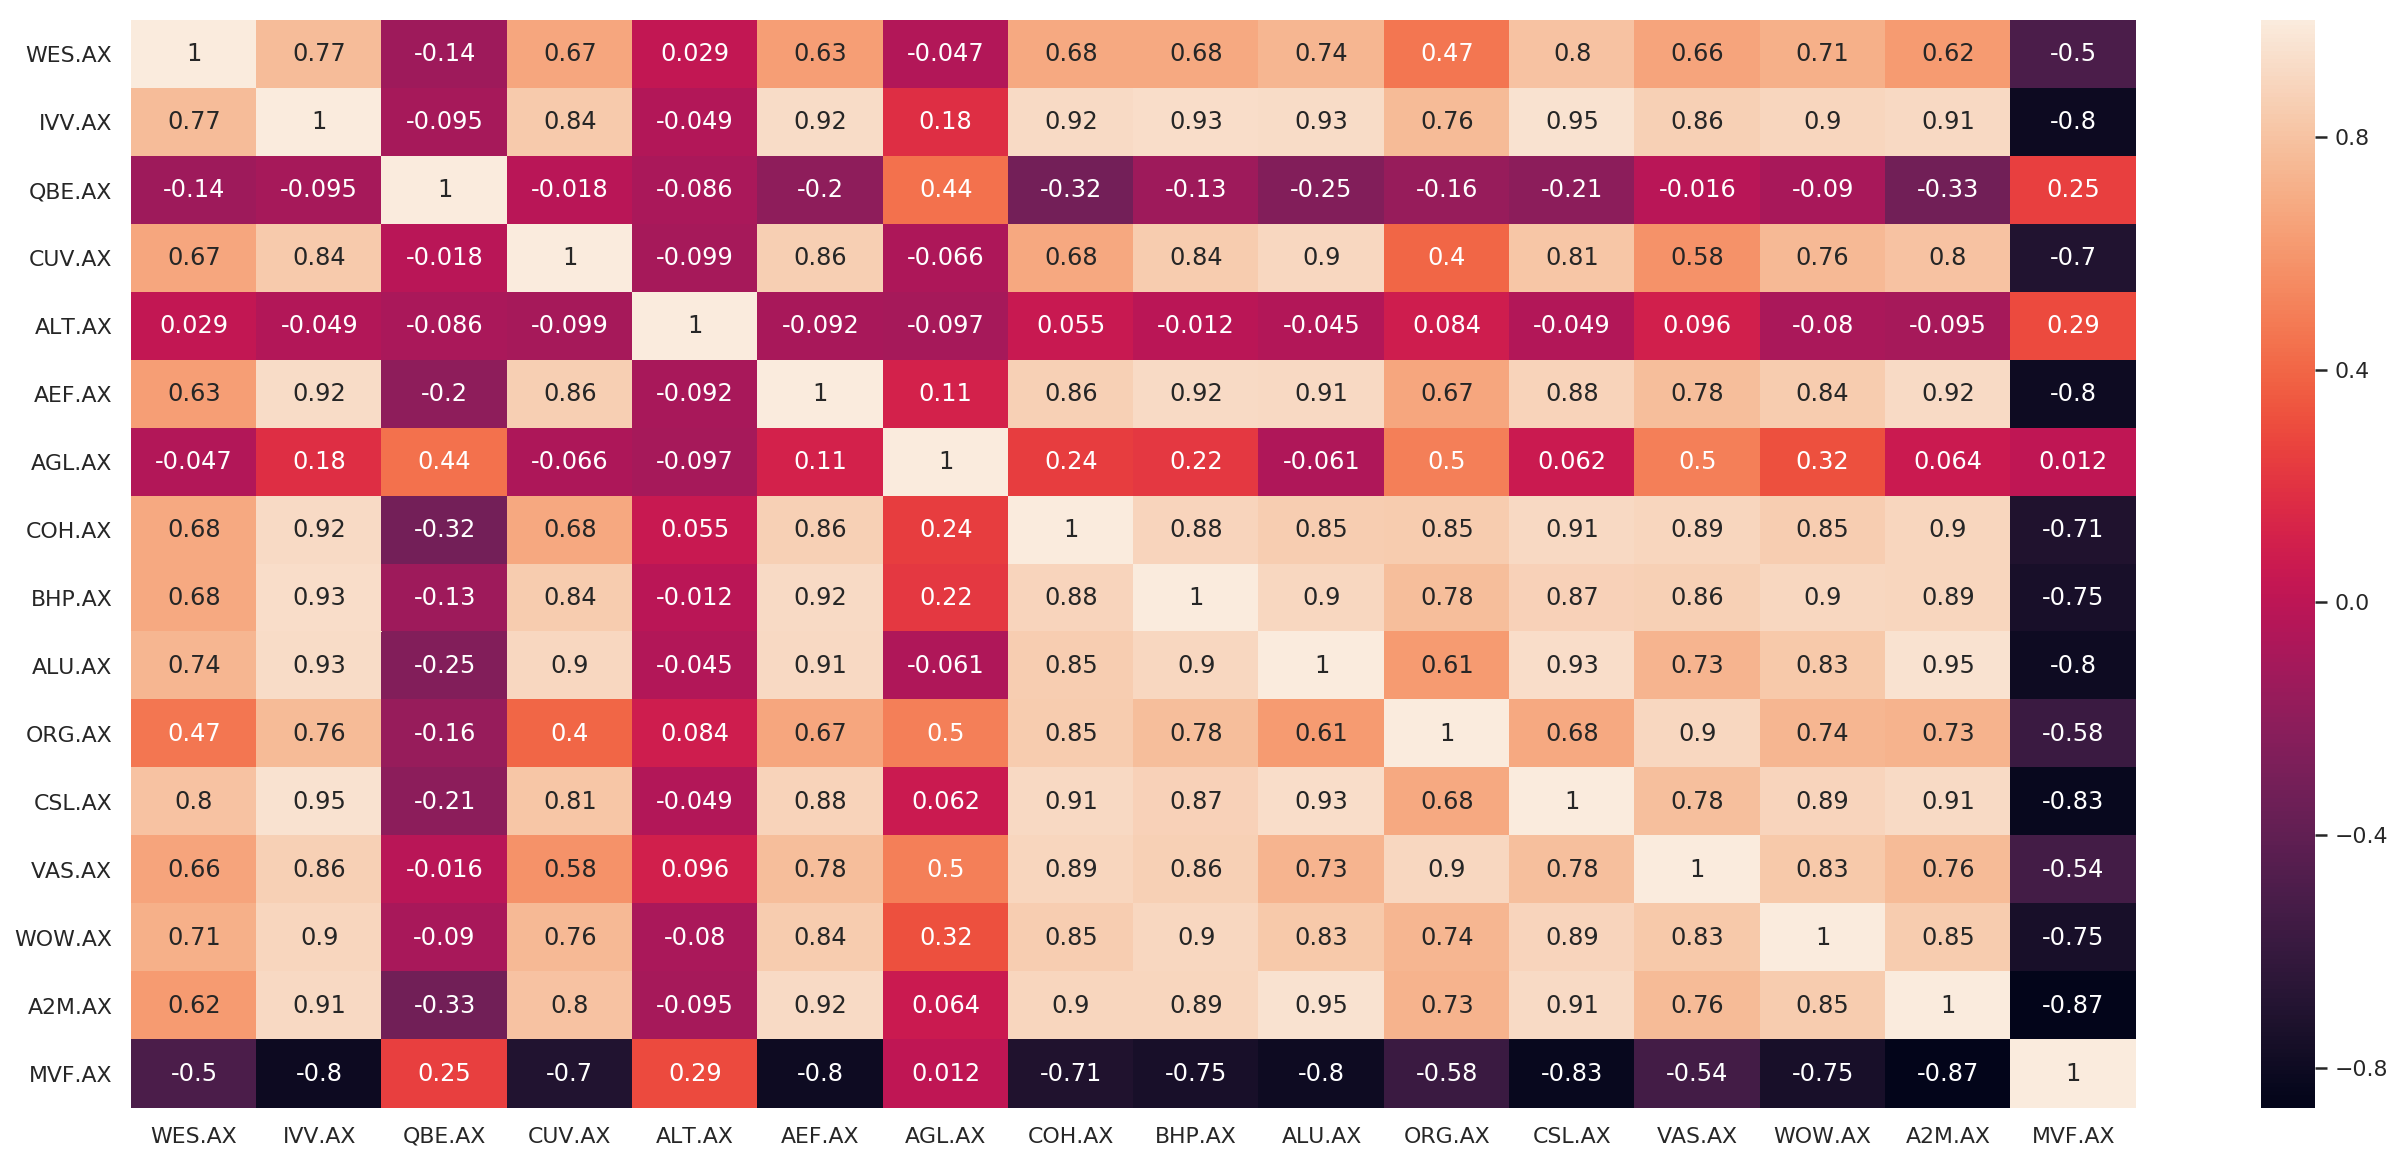

In [166]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1)

# corr_matrix = data[pd.MultiIndex.from_product([portfolio, ["Close"]])].corr()
corr_matrix = data.corr()

ax = sns.heatmap(corr_matrix, xticklabels=portfolio, yticklabels=portfolio, annot=True, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

# Custom Functions

In [ ]:
def moving_average(array, window):
    
    weights = np.repeat(1.0, window)/window
    moving_average = np.convolve(array, weights, 'valid')
    
    return moving_average

In [191]:
# Todo: Plot this!

def get_trade_points(prices, mean_prices):
    """

    :param data: 1-dimensional array-like
    :param portfolio: list
    :param short_term_metric: str., optional
    :param long_term_metric: str., optional
    return 1-dimensional array-like
    """
    
    difference = prices - mean_prices
    gradient = np.gradient(difference)

    zero_indices = np.argwhere(np.nan_to_num(np.diff(np.sign(difference)))).flatten()

#     sell_indices = np.intersect1d(zero_indices, np.where(gradient < 0)[0])

    buy_indices = np.intersect1d(zero_indices, np.where(difference < 0)[0])

#     buy_indices = np.intersect1d(zero_indices, np.where(gradient > 0)[0])

    sell_indices = np.intersect1d(zero_indices, np.where(difference > 0)[0])

    return buy_indices, sell_indices

# Plots

In [192]:
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook

linewidth = 3

x = data.index
y = x

p = figure(plot_width = 900, plot_height = 600, title = 'Close Price', 
           x_axis_label = 'Date [Days]', x_axis_type='datetime', y_axis_label = 'Price')

# To show in notebook
output_notebook()


p.outline_line_color = None

p.xgrid.visible = False
p.ygrid.visible = False

p.xgrid.visible = False
p.ygrid.visible = False

p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

p.xaxis.axis_line_width = 0
p.xaxis.axis_line_color = None

p.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

p.yaxis.axis_line_width = 0
p.yaxis.axis_line_color = None

price_plot = p.line(x, y, line_width=linewidth, color="blue", legend="Price", alpha=0.5, line_dash="solid", muted_alpha=0)
mean_plot = p.line(x, y, line_width=linewidth, color="red", legend="Rolling mean 15", alpha=0.5, muted_alpha=0)
buy_plot = p.circle(x, y, size=8, color="blue", alpha=1, fill_color="white", legend="Buy", muted_alpha=0)    
sell_plot = p.circle(x, y, size=8, color="red", alpha=1, fill_color="white", legend="Sell", muted_alpha=0)    
    
def update(feature):
    
    prices = data.loc[:, feature].values
    mean = data.loc[:, feature].ewm(span=15, adjust=False).mean()
    
    assert len(prices) == mean.shape[0]
    
    price_plot.data_source.data['y'] = prices
    mean_plot.data_source.data['y'] = mean
    
    buy_indices, sell_indices = get_trade_points(prices, mean)
    
    mask_buy = data[feature].index[buy_indices]
    buy_plot.data_source.data['x'] = data.loc[mask_buy, feature].index
    buy_plot.data_source.data['y'] = data.loc[mask_buy, feature].values
    
    assert len(data.loc[mask_buy, feature].index) == len(data.loc[mask_buy, feature].values)
    
    mask_sell = data[feature].index[sell_indices]
    
    sell_plot.data_source.data['x'] = data.loc[mask_sell, feature].index
    sell_plot.data_source.data['y'] = data.loc[mask_sell, feature].values
    
    assert len(data.loc[mask_sell, feature].index) == len(data.loc[mask_sell, feature].values)

    push_notebook()

p.legend.location = "top_left"

# Click in the legend to remove the corresponding line
p.legend.click_policy="mute"

show(p, notebook_handle=True)

interact(update, feature=portfolio)

Loading BokehJS ...

interactive(children=(Dropdown(description='feature', options=('WES.AX', 'IVV.AX', 'QBE.AX', 'CUV.AX', 'ALT.AX…

<function __main__.update(feature)>

# References

* 1. How to Apply a Basic Market Filter to the S&P/ASX 200 to Reduce Portfolio Risk and Limit Losses. src:  https://www.marketindex.com.au/asx-filter
*2 . Python for Finance, Part 3: Average Trading Strategy https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/


# Useless code

In [110]:
linewidth = 3
metric = "Cum Sum Pct Change"
# create a color iterator
colors = itertools.cycle(palette) 
rolling_columns = [days for days in data[share].columns.values.squeeze() if re.search("Rolling mean \d+", days)]
rolling_columns = ['Rolling mean 15', 'Rolling mean 90']

for share in portfolio:
    p = figure(plot_width = 900, plot_height = 600, title = '{}'.format(share), 
               x_axis_label = 'Date [Days]', x_axis_type='datetime', y_axis_label = 'Values')

    p.outline_line_color = None

    p.xgrid.visible = False
    p.ygrid.visible = False

    p.xgrid.visible = False
    p.ygrid.visible = False

    p.xaxis.major_tick_line_color = None  # turn off x-axis major ticks
    p.xaxis.minor_tick_line_color = None  # turn off x-axis minor ticks

    p.xaxis.axis_line_width = 0
    p.xaxis.axis_line_color = None

    p.yaxis.major_tick_line_color = None  # turn off y-axis major ticks
    p.yaxis.minor_tick_line_color = None  # turn off y-axis minor ticks

    p.yaxis.axis_line_width = 0
    p.yaxis.axis_line_color = None
    
    # muted_alpha controls the opacity of the line, when muted. muted_color controls the color

    p.line(data.loc[:, (share, metric)].index, data.loc[:, (share, metric)].values, line_width=linewidth, color="blue", legend="Cum Sum Pct Change", alpha=0.25, line_dash="solid")
    for color, rol_col in zip(colors, rolling_columns):
        p.line(data.loc[:, (share, metric)].index, data.loc[:, (share, rol_col)].values, line_width=linewidth, color=color, legend=rol_col, alpha=0.75, muted_alpha=0)
    
    mask_buy = data.loc[:, (share, "Trade")] == "Buy"
    p.circle(data[mask_buy].index, data.loc[mask_buy, (share, metric)].values, size=8, color="blue", alpha=1, fill_color="white", legend="Buy", muted_alpha=0)    
    
    mask_sell = data.loc[:, (share, "Trade")] == "Sell"
    p.circle(data[mask_sell].index, data.loc[mask_sell, (share, metric)].values, size=8, color="red", alpha=1, fill_color="white", legend="Sell", muted_alpha=0)    
    
    p.legend.location = "top_left"
    
    # Click in the legend to remove the corresponding line
    p.legend.click_policy="mute"
    # To show in notebook
    output_notebook()

    # Show the plot
    show(p)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [111]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)

p = figure(title="simple line example", plot_height=300, plot_width=600, y_range=(-5,5),
           background_fill_color='#efefef')
r = p.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()

show(p, notebook_handle=True)

interact(update, f=["sin", "cos"], w=(0,50), A=(1,10), phi=(0, 20, 0.1))

Loading BokehJS ...

interactive(children=(Dropdown(description='f', options=('sin', 'cos'), value='sin'), IntSlider(value=1, descr…

<function __main__.update(f, w=1, A=1, phi=0)>